# Adaptive Sampling Methods for Mutation Detection in DNA Sequences

In the field of genomics, one of the most crucial tasks is identifying and characterizing mutations in DNA sequences. These mutations can lead to various diseases including cancers, neurological disorders, and genetic abnormalities. Fast and accurate detection of these mutations can provide crucial information for understanding the genetic basis of these diseases and for designing effective therapies.

In this Python programming assignment, you are tasked to develop a tool that uses adaptive sampling methods for mutation detection in DNA sequences. The methods are based on one of the readings you read in week 3: [Gan, K., Jia, S., Li, A., & Tayur, S. R. (2021). Toward a Liquid Biopsy: Greedy Approximation Algorithms for Active Sequential Hypothesis Testing](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3894600)

The authors' basic idea is that early detection of cancer would have a tremendous impact in improving survival rates of cancer, and their goal is to develop a liquid biopsy capable of detecting cancerous mutations in DNA sequenced from a blood sample. This is currently not possible, but they argue that with computational and algorithmic improvements this method might be achievable in the near future. It is indeed the subject of active research by several academic and industrial research labs.

In their approach, an algorithmic learner seeks to **identify the true hypothesis from a known set of hypotheses using the fewest number of actions**. In this assignment, we want to identify the true presence of a given harmful mutation from a known set of harmful mutations, using the smallest sample of data possible. In reality, sequencing and analyzing genetic data is expensive, and a blood-based biopsy that tested every possible mutation vs every possible position in a DNA sequence would be prohibitively expensive. In order for a test like this to be commercially viable, it would have to know which mutations / sequence positions to prioritize. Adaptive sampling is a strategy that can select and focus on important samples, thereby increasing the efficiency and accuracy of mutation detection. This technique can help save computational resources by focusing on the regions of the DNA sequence that are most likely to contain mutations, rather than analyzing the entire sequence.

Because there is quite a bit of relevant biology background knowledge required to study this problem in detail, in this assignment, we will use a simplified synthetic dataset to understand how active sequential hypothesis testing can assist in detecting different mutations. You will be provided with a set of simulated DNA sequence data, including sequences with both harmful as well as benign mutations introduced at random locations.

Let's begin!

## Setting up our problem and taking an initial look at the data

We start by importing the packages we need, and then read in a "base sequence" that provides a baseline to compare mutations against. Generally speaking, all human DNA is mostly almost the same, with very small variations representing natural mutation variation. 

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
from progressbar import ProgressBar
from sklearn.metrics import f1_score
import numpy as np

In [2]:
with open('base_sequence.txt', "r") as text_file:
    base_sequence = text_file.readlines()[0]

This is what a snippet of the sequence looks like - it is a 10,000 character sequence of randomly generated nucleotides (adenine (A), cytosine (C), guanine (G) and thymine (T)). 

In [3]:
base_sequence[:50]

'CGGGGAGGCGTGCCACCCATTATAGGAGGCGAAAAAGGATAAGGGGTTCG'

In [4]:
len(base_sequence)

10000

Next we load a set of mutations generated randomly. Generally speaking, "mutations" correspond to different subsequences on the base sequence, but there are further variations within these mutations. In our example, we have 20 different mutations of length 50, but each mutation has 100 different variations, so there are 2000 possible mutation/variation combinations to test for. These were generated by taking the base sequence, selecting substrings of length 50 from randomly generated mutation indices, and changing individual nucleotides randomly with a probability of 5% to create the variations. 

In reality, there were some instances where either the variation was the same as the base sequence or there were otherwise duplicates, so we did not end up with the full set of 2000. 

For any given variation, there was a 5% chance it would be considered "harmful". We can take a look at what those look like:

In [5]:
mutations_df = pd.read_csv('mutation_variants.csv')

In [6]:
mutations_df

,mutation_id,mutation_variant,mutation_start,mutation_end,full_mutated_sequence,mutated_subsequence,harmful
0,1,0,3301,3351,CGGGGAGGCGTGCCACCCATTATAGGAGGCGAAAAAGGATAAGGGG...,GGCTTACCACTACACCTCACAATAGAGTTGAACGTCAAATTCAGTT...,False
1,1,1,3301,3351,CGGGGAGGCGTGCCACCCATTATAGGAGGCGAAAAAGGATAAGGGG...,GGCTTTCCACTACACCTCACAATAGAGTTGAACGTCAAATTCAGTT...,False
2,1,3,3301,3351,CGGGGAGGCGTGCCACCCATTATAGGAGGCGAAAAAGGATAAGGGG...,GGCTTACCACTACACCTCACAATTGAGTTGAACGTCAAATTCAGTT...,False
3,1,4,3301,3351,CGGGGAGGCGTGCCACCCATTATAGGAGGCGAAAAAGGATAAGGGG...,GGCTTACCACTACACCTCACAATTGAGTTCAACGTCCAATTCAGTT...,False
4,1,5,3301,3351,CGGGGAGGCGTGCCACCCATTATAGGAGGCGAAAAAGGATAAGGGG...,GGCCTACCACTACACCTCACAATTGAGTTGAACGTCAAATACAGTC...,False
...,...,...,...,...,...,...,...
1804,20,95,198,248,CGGGGAGGCGTGCCACCCATTATAGGAGGCGAAAAAGGATAAGGGG...,CTTGAGACCTTAGTCCGTCATCAACACTTTTACCAGACGTTGAATT...,False
1805,20,96,198,248,CGGGGAGGCGTGCCACCCATTATAGGAGGCGAAAAAGGATAAGGGG...,CTTGAGACCTTAGTCCGTCATCAACACTTATACCAGACGTGTACTT...,False
1806,20,97,198,248,CGGGGAGGCGTGCCACCCATTATAGGAGGCGAAAAAGGATAAGGGG...,CGTGAGACCTCAGTCCGTCATCAACACTTTAACCAGACGTAGAATT...,False
1807,20,98,198,248,CGGGGAGGCGTGCCACCCATTATAGGAGGCGAAAAAGGATAAGGGG...,GTTGAGACCTTAGTCCGTCATCAACACTTTTACCAGACGTAGAATT...,False


In [7]:
mutations_df['harmful'].value_counts()

False    1730
True       79
Name: harmful, dtype: int64

In [8]:
print('%f %% of mutations considered harmful'%(len(mutations_df[mutations_df['harmful']]) * 100 / len(mutations_df))) 

4.367054 % of mutations considered harmful


Note that in our simplified example, there can be overlap between different mutations, and thus there is theoretically the possibility that even if we could build a perfect detector there would be false positives. This is not very different from reality! This is a very hard problem...

To generate a patient sample, we took this dataset, randomly sampled 1000 variations, and introduced noise by iterating through the sequence and changing nucleotides at a probability of 1%. This does simplify it a bit from reality, as each patient should theoretically only have 1 mutation (setting aside the potential overlap between mutations issue). 

In [9]:
patient_sample = pd.read_csv('patient_sample_with_noisy_values.csv')

In [10]:
patient_sample

,mutation_id,mutation_variant,mutation_start,mutation_end,full_mutated_sequence,mutated_subsequence,harmful,patient_sequence
0,18,70,8963,9013,CGGGGAGGCGTGCCACCCATTATAGGAGGCGAAAAAGGATAAGGGG...,AACATGGAGTTACCAGCAATACGATGACTTAAAGATCCGTTTCCAG...,False,CGGGGAGGCGTGCCACCCATTATAGGAGGCGAAAAAGGATAAGGGG...
1,9,10,5283,5333,CGGGGAGGCGTGCCACCCATTATAGGAGGCGAAAAAGGATAAGGGG...,CACCCTCGCCTCCATTTGTGGGAGCTTCCGTGCGTGCGCTTCGTTT...,False,CGGGGAGGCTTGCCACCCATTATAGGAGGCGAAAAAGGATAAGGGG...
2,6,44,9580,9630,CGGGGAGGCGTGCCACCCATTATAGGAGGCGAAAAAGGATAAGGGG...,ATCTACACCAGGCTATAACGTTACGCAGTTCTAGCACTGTTGGATC...,False,TGGGGAGGCGTGCCACCCATTATAGGAGGCGAAAAAGGATAAGGGG...
3,2,50,4560,4610,CGGGGAGGCGTGCCACCCATTATAGGAGGCGAAAAAGGATAAGGGG...,GTTTGCTCTGCACGATCATCAATCCGGTTACTAAACAGGAACTCGG...,True,CGGGGAGGCGTGCCACCCATTATAGGAGGCGAAAAAGGATAAGGGG...
4,10,34,1632,1682,CGGGGAGGCGTGCCACCCATTATAGGAGGCGAAAAAGGATAAGGGG...,CATGGGTGTGATCGCTGTACGTATAATGTACCGTTTACATTTACAT...,True,CGGGGAGGCGTGCCACCCATTATAGGAGGCGAAAAAGGATAAGGGG...
...,...,...,...,...,...,...,...,...
995,5,73,2154,2204,CGGGGAGGCGTGCCACCCATTATAGGAGGCGAAAAAGGATAAGGGG...,CCTCGTCTACGTTTCTCTTACGCAAGCGTACTGGCATGTTTTAACC...,False,CGGGGAGGCGTGCCACCCATTATAGGAGGCGAAAAAGGATAAGGGG...
996,12,83,4139,4189,CGGGGAGGCGTGCCACCCATTATAGGAGGCGAAAAAGGATAAGGGG...,TGATAGAATAACGCGACTAGAACCCTCTCAGTACGCGGAATCTTCC...,False,CGGGGAGGCGTGCCACGCATTATAGGAGGCGAAAAAGGATAAGGGG...
997,1,93,3301,3351,CGGGGAGGCGTGCCACCCATTATAGGAGGCGAAAAAGGATAAGGGG...,GGCTTACCACTACACCTCACAATTGGGTTGAACGTCAAATTCAGTT...,False,CGGGGAGGCGTGCCACCCATTATAGGAGGCGAAAAAGGATAAGGGG...
998,10,47,1632,1682,CGGGGAGGCGTGCCACCCATTATAGGAGGCGAAAAAGGATAAGGGG...,CAGGGGTGTGATCGCTGCACGTATTATGTACCGTTTACATTTACGT...,False,CGGGGAGGCGTGCCACCCATTATAGGAGGCGAAAAAGGATAAGGGG...


We do in fact see that some mutations occur more frequently than others:

In [11]:
patient_sample['mutation_id'].value_counts()

18    62
10    61
2     60
13    59
19    58
3     57
8     54
7     54
16    53
15    52
14    52
6     47
11    46
5     46
1     45
9     43
17    40
20    39
4     37
12    35
Name: mutation_id, dtype: int64

In [12]:
patient_sample['harmful'].value_counts()

False    959
True      41
Name: harmful, dtype: int64

In [13]:
print('%f %% of patients have a harmful mutation'%(len(patient_sample[patient_sample['harmful']]) * 100 / len(patient_sample))) 

4.100000 % of patients have a harmful mutation


Let's take a look at the indices in the sequence where these mutations most often occur. We've done some analysis to help identify where specific mutations occur already. 

In [14]:
harmful_mutations = pd.read_csv('harmful_mutations_summary.csv', converters={'indices':eval} )

In [15]:
harmful_mutations

,mutation_id,mutation_variant,mutation_start,mutation_end,full_mutated_sequence,mutated_subsequence,harmful,indices
0,1,14,3301,3351,CGGGGAGGCGTGCCACCCATTATAGGAGGCGAAAAAGGATAAGGGG...,GGCTTACCTCTACACCCCACAATAGAGTTGAACGCCAAATTCAGAT...,True,"[3309, 3317, 3324, 3335, 3345]"
1,1,23,3301,3351,CGGGGAGGCGTGCCACCCATTATAGGAGGCGAAAAAGGATAAGGGG...,GGCTTACATCTATACCTCACAATTGAGTTGAACGTCATATTCAGTT...,True,"[3308, 3309, 3313, 3338]"
2,1,46,3301,3351,CGGGGAGGCGTGCCACCCATTATAGGAGGCGAAAAAGGATAAGGGG...,GGCGAACCACTAGACCTCACAATTGAGTTCAACGTCAAATTCAGTT...,True,"[3304, 3305, 3313, 3330]"
3,1,49,3301,3351,CGGGGAGGCGTGCCACCCATTATAGGAGGCGAAAAAGGATAAGGGG...,GGCTTACCACTGCACCTCACAATTGAATTGAACGGCAAATTCAGTT...,True,"[3312, 3327, 3335]"
4,1,57,3301,3351,CGGGGAGGCGTGCCACCCATTATAGGAGGCGAAAAAGGATAAGGGG...,GGCTTACCACTACACCTCACAATTGAGTTGAACGTCAAAGGCAGTT...,True,"[3340, 3341]"
...,...,...,...,...,...,...,...,...
74,18,47,8963,9013,CGGGGAGGCGTGCCACCCATTATAGGAGGCGAAAAAGGATAAGGGG...,AACCTGGAGTTACCAGCAATACGATGACTTAAAGATCCTTTTTCAG...,True,"[8966, 9001, 9012]"
75,19,38,1032,1082,CGGGGAGGCGTGCCACCCATTATAGGAGGCGAAAAAGGATAAGGGG...,TATGCCTTATCCACATCATGACGTCGAGGCTAATCGATGCACTCTA...,True,[1074]
76,19,50,1032,1082,CGGGGAGGCGTGCCACCCATTATAGGAGGCGAAAAAGGATAAGGGG...,TATGCCTTATCCACATCAAGACGTCGAGGCTAATCGATGCACGCTA...,True,"[1050, 1078]"
77,20,90,198,248,CGGGGAGGCGTGCCACCCATTATAGGAGGCGAAAAAGGATAAGGGG...,CTTGAGACCTTAGTCCGTCATCAACACTTGTACCAGACGTAGAATT...,True,[227]


In [16]:
harmful_indices = []

for i in harmful_mutations['indices'].tolist():
    harmful_indices.extend(i)

You can see the most common harmful indices here both by raw counts as well as a histogram/kernel density plot. Don't read too far into the kernel density since these are discrete index positions with fixed locations - it's just to help you understand that some areas of the sequence are more commonly associated with harmful mutations than others. 

In [17]:
harmful_mutation_position_distribution = pd.Series(harmful_indices).value_counts().reset_index()
harmful_mutation_position_distribution.columns = ['position', 'frequency']
harmful_mutation_position_distribution['p'] = harmful_mutation_position_distribution['frequency'] / harmful_mutation_position_distribution['frequency'].sum()
harmful_mutation_position_distribution

,position,frequency,p
0,9603,3,0.014354
1,4898,3,0.014354
2,1656,2,0.009569
3,4899,2,0.009569
4,4883,2,0.009569
...,...,...,...
174,3426,1,0.004785
175,9624,1,0.004785
176,3553,1,0.004785
177,9590,1,0.004785


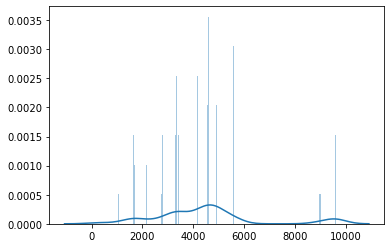

In [18]:
fig, ax = plt.subplots()
sns.distplot(harmful_indices, ax=ax, bins=1000)

# Intro to adaptive sampling

At this point you might be wondering what all of this is about. Recall from the paper that we have a finite set of hypotheses, among which exactly one is the unknown true hypothesis we seek to identify from chooseing from a potentially large set of actions. Here those candidate hypotheses are different types of cancers, and actions correspond to sequencing individual DNA addresses. 

We are using a synthetic dataset to compare how our method works vs. a "ground truth", but in reality we wouldn't have all of this information sequenced, and we wouldn't know if a given patient had a harmful mutation or not. In our sampling approach, we incur a fixed cost each time an action is selected and we seek to identify the true hypothesis with sufficient confidence at minimum total cost. We are allowed to select actions adaptively, and one technique to do this is to lean on our known distribution of harmful indices - this is basically a probability distribution function that we can select from! 

However in this problem we run into the classic explore/exploit tradeoff - our sampling approach COULD just use the most common harmful indices, but we might miss more rare mutations that way. So we have to also figure out the right balance between exploring possibilities and exploiting known information. 

For your first task, write a function called `choose_next_sample` to start to do this, based on a list of previous choices. For the first choice, the length of this list would be 0. It will take in the dataframe above w/ the probability distribution function (in the function we're calling it `pdf` but you'll call the function with the `harmful_mutation_position_distribution` dataframe), the list of previous choices (`previous_choices`), and a parameter called `exploit_value` in the range 0-1 that allows you to probabilistically choose between exploring and exploiting (0 being full explore, 1 being full exploit). 

In [19]:
def choose_next_sample(pdf, previous_choices, exploit_value):
    
     # Filter previous choices from PDF and rank by probability
    
    # If exploiting, take most likely PDF value
    
    # If exploring, pick a random value
        
    ### BEGIN SOLUTION
    
    pdf = pdf[~pdf['position'].isin(previous_choices)].sort_values(by='p', ascending=False)
    
    if random.random() < exploit_value:
        chosen_index = int(pdf.iloc[0]['position'])
    else:
        chosen_index = int(pdf.sample(1).iloc[0]['position'])
    
    ### END SOLUTION
    
    return chosen_index

In [20]:
# Here are some basic tests you can use to make sure your function is working.

assert choose_next_sample(harmful_mutation_position_distribution, previous_choices=[], exploit_value=1) == 9603 
assert choose_next_sample(harmful_mutation_position_distribution, previous_choices=[9603], exploit_value=1) == 4898 

In [21]:
# There are some hidden tests we are using as well.. 

### BEGIN HIDDEN TESTS

harmful_mutation_position_distribution = harmful_mutation_position_distribution.sort_values(by='p', ascending=False)

# Test for exploit 
selected_positions = []

for i in range(len(harmful_mutation_position_distribution)):
    choice = choose_next_sample(harmful_mutation_position_distribution, selected_positions, exploit_value=1)
    selected_positions.append(choice)
    
    
assert selected_positions == harmful_mutation_position_distribution['position'].to_list(), 'You are not setting up exploit properly.'

# Test for explore
selected_positions = []

for i in range(len(harmful_mutation_position_distribution)):
    choice = choose_next_sample(harmful_mutation_position_distribution, selected_positions, exploit_value=0.5)
    selected_positions.append(choice)


assert selected_positions != harmful_mutation_position_distribution['position'].to_list(), 'You are not setting up explore properly.'

### END HIDDEN TESTS

We'll use our function now to create a list of indices corresponding to a given sample length. 

In [22]:
def select_positions(sample_length, exploit_value):
  
    selected_positions = []
    
    for i in range(sample_length):
        selected_position = choose_next_sample(harmful_mutation_position_distribution, 
                                               previous_choices=selected_positions, 
                                               exploit_value=exploit_value)
        selected_positions.append(selected_position)
  
    return selected_positions

Given a sampled list of indices to check, here is a function to cross reference a given patient sequence against the base sequence and mutation list to determine if there are harmful mutations. 

In [23]:
def search_for_harmful_mutations(patient_sequence, selected_positions):

    possible_mutations = []

    for position in selected_positions:

        # Only check mutations if patient differs from base sequence at selected position
        if patient_sequence[position] != base_sequence[position]:

            # Only check mutations containing selected position 
            relevant_harmful_mutations = harmful_mutations[(harmful_mutations['mutation_start'] <= position) & 
                                                        (harmful_mutations['mutation_end'] >= position)]

            # Search through possible matches and return relevant mutation id/variant combinations         
            if len(relevant_harmful_mutations) > 0:       
                relevant_harmful_mutations = relevant_harmful_mutations.reset_index(drop=True)

            for mutation_index in relevant_harmful_mutations.index:
                mutation_sequence = relevant_harmful_mutations.iloc[mutation_index]['full_mutated_sequence']
                if mutation_sequence[position] == patient_sequence[position]:
                    possible_mutations.append([relevant_harmful_mutations.iloc[mutation_index]['mutation_id'],
                                              relevant_harmful_mutations.iloc[mutation_index]['mutation_variant']])

    return possible_mutations

Here is a given example run with this w/ a very short sample length of 10, and an exploit value of 0.8. 

In [24]:
selected_positions = select_positions(sample_length=10, exploit_value=0.8)
patient_results = []
pbar = ProgressBar()

for patient_index in pbar(patient_sample.index):
    patient_sequence = patient_sample.iloc[patient_index]['full_mutated_sequence']
    possible_mutations = search_for_harmful_mutations(patient_sequence, selected_positions)
    patient_results.append(possible_mutations)

100% (1000 of 1000) |####################| Elapsed Time: 0:00:00 Time:  0:00:00


Let's do some analysis looking at how this did. First we want to see what if any mutations were identified, and flag if they are harmful. 

Here we are basically turning it into a binary classification problem based on if the harmful mutation was identified (True if yes) in the returned possible mutations, and False if no mutation/ only wrong mutations detected. Technically this should probably be a  multi-class classification problem, but we don't have a probability score associated with a given mutation, so this doesn't really work. 

Next, we need a metric to quantify effectiveness of our detector. Since there is a [class imbalance problem](https://machinelearningmastery.com/failure-of-accuracy-for-imbalanced-class-distributions/), accuracy doesn't work as a great performance metric, so we use the [f1 score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html). 

In [25]:
patient_sample['test_results'] = patient_results
patient_sample['mutation_hits'] = patient_sample['test_results'].apply(lambda x: len(x))
patient_sample['harmful_mutation_identified_correctly'] = patient_sample.apply(lambda x: [x['mutation_id'],
                                                                                          x['mutation_variant']] in x['test_results'], 
                                                                                axis=1)
score = f1_score(patient_sample['harmful'], patient_sample['harmful_mutation_identified_correctly'])

In [26]:
print('f1 score: %f'%(score))

f1 score: 0.392157


So based on this score we can see this isn't doing particularly well to start. Recall that f1 score combines both precision and recall and a perfect score would be 1 - we can check that by running: 

In [27]:
score = f1_score(patient_sample['harmful'], patient_sample['harmful'])

In [28]:
print('f1 score: %f'%(score))

f1 score: 1.000000


# Optimizing the sampling approach

At this point you are hopefully starting to wonder how we can tune this approach to come up with a more useful sampling approach capable of maximizing detection of harmful mutation while minimizing false positives as well as costs of sequencing. There are 2 main levers we have: 

1. **Adjusting the sample length** - longer sample lengths are more likely to detect more harmful mutations, but are going to be more costly. 
2. **Adjusting the explore vs. exploit ratio** - we want to exploit knowledge of where we expect the most likely mutations to occur, but we also want to make sure we explore more marginal possibilities. 

One thing to keep in mind with varying explore/exploit parameters is that even with the same sample length we will have some variation in what we pull back and thus the performance. To deal with this, we will create an ensemble for each sample length/exploit ratio and create a confidence interval to evaluate performance. 

Let's start by generating some sample lengths and explore/exploit ratios to test, and then we'll use those parameters to search for harmful mutations. We limited the combinations in order to shorten the time it takes to run (it will still take a few minutes), but you might find it interesting to explore more potential combinations or run more iterations to create a bigger ensemble. 

In [29]:
sample_lengths = np.arange(10, 179, 20)
exploit_values = np.arange(0, 1.1, 0.2)

In [30]:
pbar = ProgressBar()
results = []

for sample_length in pbar(sample_lengths):
  
    # Try different exploit values 
    for exploit_value in exploit_values:

        # Create ensemble to get distribution of f1-scores for multiple iterations of sample lengths/exploit values
        for iter in range(10):

            selected_positions = select_positions(sample_length=sample_length, exploit_value=exploit_value)
            patient_results = []

            for patient_index in patient_sample.index:
                patient_sequence = patient_sample.iloc[patient_index]['full_mutated_sequence']
                possible_mutations = search_for_harmful_mutations(patient_sequence, selected_positions)
                patient_results.append(possible_mutations)

            patient_sample['test_results'] = patient_results
            patient_sample['mutation_hits'] = patient_sample['test_results'].apply(lambda x: len(x))
            patient_sample['harmful_mutation_identified_correctly'] = patient_sample.apply(lambda x: [x['mutation_id'], x['mutation_variant']] in x['test_results'], axis=1)
            score = f1_score(patient_sample['harmful'], patient_sample['harmful_mutation_identified_correctly'])

            results.append([sample_length, exploit_value, score])

100% (9 of 9) |##########################| Elapsed Time: 0:07:35 Time:  0:07:35


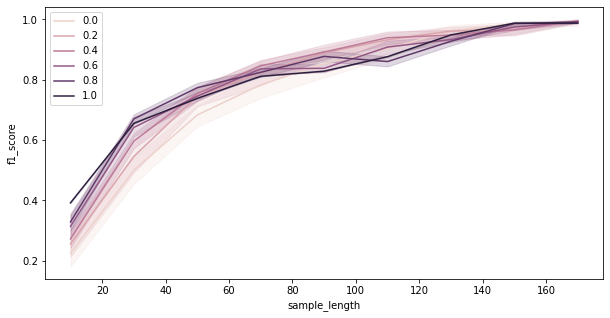

In [31]:
results_df = pd.DataFrame(results, columns=['sample_length', 'exploit_value', 'f1_score'])

plt.figure(figsize=(10,5))
sns.lineplot(x=results_df['sample_length'], 
             y=results_df['f1_score'], 
             hue=results_df['exploit_value'])
plt.legend([round(i, 2) for i in results_df['exploit_value'].unique()])
plt.show()

You should be able to pull out a few interesting trends here:
+ **Increasing sample length dramatically improves f1 score when sample length is low and it begins to taper off before achieving perfect performance**. This should intuitively make sense. If we only sample a few known harmful locations, it makes sense that we would not be able to detect even close to all harmful mutations, whereas if we sample all known harmful locations, we should be able to detect all of them.
+ **At low sample size, exploit does a better job of identifying harmful mutations, but as sample sizes increase, using more explore actually outperforms exploit, until they converge as sample length appraoches the full length of all candidate hypotheses**. This should also intuitively make sense - at lower sample sizes we want to prioritize the most frequent harmful mutations, but as sample size increases we want to explore more to cover rarer possibilities. 

There is still the question of "Well, how do we choose what do do?" You'll write some code to help find out! Let's write a function called `choose_best_exploit` that takes in our results dataframe, filters to a given `sample length`, and identifies the exploit value that maximizes mean f1 score. 

In [41]:
def choose_best_exploit(df, sample_length):
    
    ### BEGIN SOLUTION
    sample_values = df[df['sample_length'] == sample_length]
    sample_values = sample_values.groupby('exploit_value').agg('f1_score').mean().reset_index()
    exploit_value = sample_values.loc[sample_values['f1_score'].idxmax()]['exploit_value']
    ### END SOLUTION
    
    return exploit_value
    

In [52]:
# Here are some tests to help you make sure you've got it. 

assert choose_best_exploit(results_df, 10) == 1
assert choose_best_exploit(results_df, 110) != 1

In [57]:
# A few hidden tests to help us grade. 

### BEGIN HIDDEN TESTS

# Not really sure how best else to make these different since we get noise 
assert choose_best_exploit(results_df, 10) == 1
assert choose_best_exploit(results_df, 110) != 1

### END HIDDEN TESTS


In [58]:
sample_lengths

array([ 10,  30,  50,  70,  90, 110, 130, 150, 170])

Let's say it costs \\$1 per index location and we want our test to cost \\$70. What would be the best explore ratio to use? 

In [59]:
choose_best_exploit(results_df, 70)

0.4

Let's assess what the performance actually looks like on this:

In [71]:
results_df[(results_df['sample_length'] == 70) & (results_df['exploit_value'] == 0.4)]['f1_score'].mean()

0.8460989100508683

Generally speaking, not bad! That's much better than our first attempt, though still not necessarily perfect. What if we decide to increase to a \\$90 sample? 

In [62]:
choose_best_exploit(results_df, 90)

0.4

In [70]:
results_df[(results_df['sample_length'] == 90) & (results_df['exploit_value'] == 0.4)]['f1_score'].mean()

0.8920145953779695

It does seem like adding \\$20 might be worth it! What if we keep going up?

In [66]:
choose_best_exploit(results_df, 110)

0.4

In [68]:
results_df[(results_df['sample_length'] == 110) & (results_df['exploit_value'] == 0.4)]['f1_score'].mean()

0.9394556578234736

We are still seeing improvements - which remember, we should expect. As the sample length increases, we get better precision & recall on  detecting harmful mutations. 

Remember though, this is a bit of a contrived example - in reality, we would want to test for many thousands if not potentially millions of mutation variations. The difference between spending \\$70 vs. \\$170 on a blood test in reality would be worth the gains in detection abilities. After all, if you fail to detect a disease and treat it early, you would likely spend much more than \\$100 on later treatment, so paying that marginal cost to detect the disease early enough to treat it would be very worth it. However, the vast majority of people cannot pay \\$1 million for a blood test, so in order for this kind of test to be commercially viable, it would have to cost much lower, and a decision would need to be made somehow as to what cost and error tolerance balance is acceptable. 

In conclusion, we hope that this assignment has started to give you more insight into the nuanced challenges of implementing an adaptive sampling algorithm in the domain of genomics. Problems that would benefit from adaptively sampling approaches show up across disciplines, and we hope that this has started to give you an idea of the power of these ideas. 